<a href="https://colab.research.google.com/github/alex-jk/SWB-GVCEH/blob/main/models/relevance_model/Reddit_Relevancy_Models_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Install and import necessary libraries

In [2]:
!pip install setfit
!pip install tqdm
!pip install gdown

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import gdown
import json
import pandas as pd

Mounted at /content/drive


In [6]:
from setfit import SetFitModel
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")

from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import concurrent.futures

import numpy as np
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

model_sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

##### Import the full Reddit dataset
- remove duplicates to make sure that posts are unqiue
- TitleText is the text column of interest

In [7]:
file_path = '/content/drive/My Drive/SWB-GVCEH/Complete_Data_v3.json'
reddit_data_df = pd.read_json(file_path)

print(f"\ncd_test shape: {reddit_data_df.shape}")
print(f"\n--------------- Columns: {reddit_data_df.columns}")

select_cols = ['Subreddit', 'Title', 'Text', 'TitleText']
reddit_data_df = reddit_data_df[select_cols]
reddit_data_df.drop_duplicates(inplace=True)
reddit_data_df.reset_index(drop=True, inplace=True)

print("\n------------------------------")
print(reddit_data_df.head())


cd_test shape: (11160, 23)

--------------- Columns: Index(['index', 'Subreddit', 'Title', 'Text', 'TitleText', 'relevance_score',
       'most_common_centroid_id', 'top_terms_from_centroid',
       'topics_from_centroid', 'Score_model2', 'label_model2', 'label_model1',
       'relevant_sentences', 'topic_num', 'Relevant_document',
       'Relevant_topic', 'topic_label', 'Sentiment_Full',
       'Sentence_Level_Sentiment_Compund',
       'Relevent_Sentence_Sentiment_Compund', 'BERT_sentiment_all',
       'BERT_sentiments_relevant_sentences', 'manual_label'],
      dtype='object')

------------------------------
    Subreddit                                              Title  \
0  VictoriaBC  True change around homelessness from the homel...   
1  VictoriaBC  New transitional housing facility on Douglas o...   
2  VictoriaBC   Where to buy a reasonably priced Christmas tree?   
3  VictoriaBC  Looking for a Christmas tree? Please consider ...   
4  VictoriaBC                           

#### Import Twitter Data

In [8]:
file_path = '/content/drive/My Drive/SWB-GVCEH/tweets_combined_df.csv'
tweets_combined_df = pd.read_csv(file_path)

print("\ntweets_combined_df data ----------------")
print(tweets_combined_df.shape)
print(tweets_combined_df.columns)
print(tweets_combined_df.head())


tweets_combined_df data ----------------
(5435, 17)
Index(['Unnamed: 0', 'text', 'scrape_time', 'tweet_id', 'created_at',
       'reply_count', 'quote_count', 'like_count', 'retweet_count',
       'geo_full_name', 'geo_id', 'username', 'num_followers',
       'search_keywords', 'search_neighbourhood', 'sentiment', 'score'],
      dtype='object')
   Unnamed: 0                                               text  \
0           0  RT pressjournal: Colonsay islanders and people...   
1           1  Colonsay islanders and people who have left th...   
2           7  @ArianeBurgessHI Serviced plots for 25k are ex...   
3           9  RT @VicBuilders: "25-unit townhome development...   
4          27  @OurNewHomecoach @laughatthemoon2 There is so ...   

                  scrape_time             tweet_id                 created_at  \
0  2023-02-07 03:20:43.040309  1622564995115503616  2023-02-06 11:56:55+00:00   
1  2023-02-07 03:20:43.040317  1622550741599625221  2023-02-06 11:00:16+00:00   

#### Reddit Data Labelling - Model #1
Perform K-Means clustering of twitter data

Generate embeddings of twitter posts

In [ ]:
twitter_embeddings = model_sent_transformer.encode(tweets_combined_df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

#### Run K-Means on twitter embeddings

Current k: 1
Current k: 2
Current k: 3
Current k: 4
Current k: 5
Current k: 6
Current k: 7
Current k: 8
Current k: 9
Current k: 10
Current k: 11
Current k: 12
Current k: 13
Current k: 14
Current k: 15
Current k: 16
Current k: 17
Current k: 18
Current k: 19
Current k: 20
Current k: 21
Current k: 22
Current k: 23
Current k: 24
Current k: 25
Current k: 26
Current k: 27
Current k: 28
Current k: 29
Current k: 30
Current k: 31
Current k: 32
Current k: 33
Current k: 34
Current k: 35
Current k: 36
Current k: 37
Current k: 38
Current k: 39


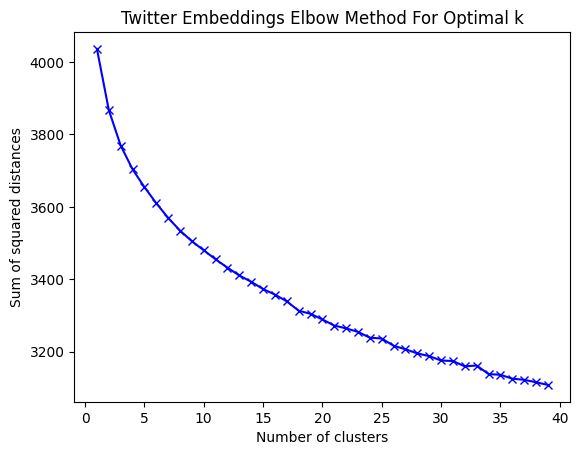

In [ ]:
# Calculate sum of squared distances for different number of clusters
Sum_of_squared_distances = []
K = range(1,40)  # Adjust the range based on your dataset
for k in K:
    print(f"Current k: {k}")
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(twitter_embeddings)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Twitter Embeddings Elbow Method For Optimal k')
plt.show()

##### Assign clusters to embeddings

In [ ]:
k = 15  # number of clusters
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(twitter_embeddings)

cluster_centroids = kmeans.cluster_centers_

tweets_combined_df['cluster'] = kmeans.labels_

print(cluster_centroids)

# Convert your numpy array to a list of lists
centroids_list = cluster_centroids.tolist()

# Save to a JSON file
with open("/content/drive/My Drive/SWB-GVCEH/twitter_cluster_centroids.json", "w") as f:
    json.dump(centroids_list, f)

[[ 0.07606746 -0.03684408  0.07050317 ... -0.04477242 -0.05458607
   0.06265755]
 [ 0.03922427 -0.00116647  0.05264552 ... -0.03459585 -0.04934484
   0.0509878 ]
 [ 0.08159573 -0.00581049  0.06172452 ... -0.05318972 -0.0436865
   0.03083117]
 ...
 [ 0.04692682  0.04268746  0.03507463 ... -0.02552383 -0.04925404
   0.03933679]
 [ 0.01194589  0.00625541  0.04830575 ... -0.04271128 -0.0092378
   0.0193102 ]
 [ 0.01649493  0.01140771  0.01363297 ... -0.05939158  0.01116832
   0.01196186]]


#### Load Twitter Centroids

In [9]:
file_path_twitter_centroids = "/content/drive/My Drive/SWB-GVCEH/twitter_cluster_centroids.json"

# Read the JSON file
with open(file_path_twitter_centroids, "r") as f:
    centroids_list = json.load(f)

cluster_centroids = np.array(centroids_list)
print(cluster_centroids)

[[ 0.07606746 -0.03684408  0.07050317 ... -0.04477242 -0.05458607
   0.06265755]
 [ 0.03922427 -0.00116647  0.05264552 ... -0.03459585 -0.04934484
   0.0509878 ]
 [ 0.08159573 -0.00581049  0.06172452 ... -0.05318972 -0.0436865
   0.03083117]
 ...
 [ 0.04692682  0.04268746  0.03507463 ... -0.02552383 -0.04925404
   0.03933679]
 [ 0.01194589  0.00625541  0.04830575 ... -0.04271128 -0.0092378
   0.0193102 ]
 [ 0.01649493  0.01140771  0.01363297 ... -0.05939158  0.01116832
   0.01196186]]


##### Functions to process reddit posts

In [10]:
# Function to split text into sentences
def spacy_sentence_split(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

# Function to process a single Reddit post and determine its relevance
def process_post_for_relevance(post, model, centroids, threshold):
    sentences = spacy_sentence_split(post)
    sentence_embeddings = model.encode(sentences, show_progress_bar=False)
    sentence_relevance_scores = cosine_similarity(sentence_embeddings, centroids)
    max_scores = sentence_relevance_scores.max(axis=1)
    max_score_indices = sentence_relevance_scores.argmax(axis=1)
    # print(len(sentence_embeddings))
    # print(max_scores)
    # print(max_score_indices)

    relevant_sentences = max_scores > threshold
    relevant_centroid_ids = max_score_indices[relevant_sentences]
    # print(relevant_centroid_ids)
    relevance_score = relevant_sentences.mean()  # Proportion of sentences above the threshold

    centroid_counter = Counter(relevant_centroid_ids)
    # print(centroid_counter)
    if len(centroid_counter) == 0:
        most_common_centroid_ids = None  # No relevant sentences
    else:
        # Find the maximum count for the centroids
        max_count = centroid_counter.most_common(1)[0][1]
        # Get all centroid IDs that have the maximum count (ties included)
        most_common_centroid_ids = [centroid_id for centroid_id, count in centroid_counter.items() if count == max_count]

    return relevance_score, most_common_centroid_ids

In [11]:
# Parallel processing function
def parallel_relevance_computation(reddit_posts, model, centroids, threshold, max_workers=10):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda post: process_post_for_relevance(post, model, centroids, threshold), reddit_posts), total=len(reddit_posts)))

    # Unpack the results into two separate lists
    relevance_scores, most_common_centroid_ids = zip(*results)
    return relevance_scores, most_common_centroid_ids

##### Assign Model #1 labels

In [12]:
def apply_model_labeling(dataframe, text_column, model, centroids, threshold_score=0.5, label_threshold=0.1):
    """
    Computes relevance scores and centroid IDs for a given DataFrame, then assigns labels based on relevance.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame to process.
    - titles_column: str, the name of the column containing text to compute relevance for.
    - model: The model used to transform text into embeddings.
    - centroids: np.ndarray, the cluster centroids used for computing relevance.
    - threshold_score: float, the threshold used within the parallel relevance computation.
    - label_threshold: float, the threshold above which the relevance score is considered significant for labeling.

    The function updates the input DataFrame with three new columns: 'relevance_score',
    'most_common_centroid_id', and 'label_model1'.
    """
    # Assuming the implementation of parallel_relevance_computation is available in your environment
    relevance_scores, most_common_centroid_ids = parallel_relevance_computation(
        dataframe[text_column].tolist(), model, centroids, threshold=threshold_score)

    # Assign the computed values to the DataFrame
    dataframe['relevance_score'] = relevance_scores
    dataframe['most_common_centroid_id'] = most_common_centroid_ids

    # Assign labels based on the relevance score threshold
    dataframe['label_model1'] = np.where(dataframe['relevance_score'] >= label_threshold, 1, 0)


In [ ]:
# Filter relevant posts based on a relevance score threshold
# reddit_data_df['label_model1'] = np.where(reddit_data_df['relevance_score'] >= 0.1, 1, 0)
apply_model_labeling(reddit_data_df, 'TitleText', model_sent_transformer, cluster_centroids, 0.5, 0.1)

relevant_reddit_posts = reddit_data_df[reddit_data_df['relevance_score'] > 0.1].reset_index(drop=True)
print(f"\nOriginal number of posts: {len(reddit_data_df.index)}")
print(f"\nNumber of relevant posts: {len(relevant_reddit_posts.index)}")

  0%|          | 0/11151 [00:00<?, ?it/s]

#### Twitter Relevancy Model on Reddit sentences - Model #2 (INITIAL VERSION)

In [ ]:
# Function to chunk a long text into smaller parts
def tokenize_into_sentences(text):
    return sent_tokenize(text)


def predict_relevance(text):
    sentences = tokenize_into_sentences(text)
    if not sentences:  # If no sentences, return default values
        return 0.0, 0

    # Assuming model(sentences) returns a tensor of predictions; convert this to a list
    predictions_tensor = model(sentences)
    predictions = predictions_tensor.tolist()  # Convert tensor to list

    # Calculate the score as a percentage of relevant sentences
    score = sum(predictions) / len(sentences) * 100
    score = round(score, 2)  # Round to 2 decimal places for readability

    # Determine binary output: 1 if 10% or more sentences are relevant, else 0
    binary_output = 1 if score >= 10 else 0

    return score, binary_output

In [ ]:
tqdm.pandas(desc="Processing Posts")

reddit_data_df[['Score_model2', 'label_model2']] = reddit_data_df['TitleText'].progress_apply(
    lambda x: pd.Series(predict_relevance(x))
)

Processing Posts:   0%|          | 0/11151 [00:00<?, ?it/s]

#### SetFit Relevancy Model - Model #2 UPDATED

##### Import train and test data
Import labelled json data

In [ ]:
file_path_sample02 = '/content/drive/My Drive/SWB-GVCEH/reddit_manual_labels_sample02.json'

reddit_manual_labels_sample02 = pd.read_json(file_path_sample02, lines=True)
print(f"\n---- df reddit_manual_labels_sample02 shape: {reddit_manual_labels_sample02.shape}")
print(f"\n Columns: {reddit_manual_labels_sample02.columns}")

print(f"\n-----------------------")
print(reddit_manual_labels_sample02.head())


---- df reddit_manual_labels_sample02 shape: (118, 11)

 Columns: Index(['Subreddit', 'Title', 'Text', 'TitleText', 'relevance_score',
       'most_common_centroid_id', 'Score_model2', 'label_model2',
       'label_model1', 'relevant_sentences', 'manual_label'],
      dtype='object')

-----------------------
         Subreddit                                              Title  Text  \
0       VictoriaBC  Victoria Womens' Flag Football League is start...  None   
1       VictoriaBC  Rowers Caileigh Filmer and Hillary Janssens wi...  None   
2  britishcolumbia  She introduced the exotic dish of pizza to CBC...  None   
3       VictoriaBC   City of Victoria Releases New Solar Rooftop Tool  None   
4            Sooke  New wrestling club launches in Sooke - Coaches...  None   

                                           TitleText  relevance_score  \
0  Victoria Womens' Flag Football League is start...              0.0   
1  Rowers Caileigh Filmer and Hillary Janssens wi...              0.

##### Split into test and train

In [ ]:
# Shuffle the DataFrame
df_shuffled = reddit_manual_labels_sample02.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled['TitleText'].fillna('', inplace=True)

split_size = int(len(df_shuffled) * 0.65)

select_cols = ['TitleText', 'manual_label']
# Split the DataFrame into two parts
sample_train = df_shuffled[:split_size][select_cols].copy().reset_index(drop=True)
sample_test = df_shuffled[split_size:][select_cols].reset_index(drop=True)
print(f"\nTrain dataset length: {len(sample_train)}, test dataset length: {len(sample_test)}")

value_counts_train = sample_train['manual_label'].value_counts()
print("\n----------------")
print(value_counts_train)

value_counts_test = sample_test['manual_label'].value_counts()
print("\n----------------")
print(value_counts_test)


Train dataset length: 76, test dataset length: 42

----------------
0    52
1    24
Name: manual_label, dtype: int64

----------------
0    27
1    15
Name: manual_label, dtype: int64


In [ ]:
train_dataset = Dataset.from_pandas(sample_train)
test_dataset = Dataset.from_pandas(sample_test)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [ ]:
import random
import torch

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # For some operations, you may also want to enable deterministic behavior in PyTorch
    # This may impact performance
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(42)

In [ ]:
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

model_id_reddit = "sentence-transformers/all-MiniLM-L6-v2"
model_reddit = SetFitModel.from_pretrained(model_id_reddit)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# Configure the SetFitTrainer
trainer = SetFitTrainer(
    model=model_reddit,
    train_dataset=dataset_dict["train"],  # training dataset
    eval_dataset=dataset_dict["test"],    # test dataset
    loss_class=CosineSimilarityLoss,      # Specify the loss class
    batch_size=8,                        # Batch size for training
    num_iterations=20,                    # Number of iterations over the training dataset
    column_mapping={"TitleText": "text", "manual_label": "label"}  # Adjust column names as needed
)

<ipython-input-32-47bd27bb75f2>:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/76 [00:00<?, ? examples/s]

In [ ]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

***** Running training *****
  Num unique pairs = 3040
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 380


Step,Training Loss


Step,Training Loss


***** Running evaluation *****


{'accuracy': 0.7380952380952381}


##### Predict

In [ ]:
predictions = trainer.model.predict(reddit_data_df["TitleText"].tolist())
reddit_data_df['label_model2_setfit'] = predictions